# Clade Labelling

This example plots a supporting visualization to a common computation: we wish to allocate (label) a bunch of sequences to clades by finding the nearest reference. As such, we first computed a tree *with* a bunch of references in there (in this case, we use WHO-recommended vaccines), then calculate the tip-to-mrca-to-reference branch distance for all 6. To choose the "closest reference" for a given sequence, we select the reference that is the *smallest distance* away from that sequence. 

All that's already been done, and the results are in `H3_clade_labels.nex`. The `clade_label_iso_name` column shows the nearest reference. 

Also note that I initially put in *too many* vaccines, and ended up only computing the nearest reference using only some of them. Of the 7 vaccine sequences in the tree, only 5 are used (redundant ones crossed out). The full tip names are:

* A/H3N2|A/Singapore/INFIMH-16-0019/2016|Singapore|2016-06-14
* A/H3N2|A/HongKong/4801/2014|HongKong|2014
* A/H3N2|A/SouthAustralia/55/2014|Australia|2014-06-29
* ~~A/H3N2|A/Switzerland/9715293/2013|Switzerland|2013-12-06~~
* ~~A/H3N2|A/Stockholm/6/2014|Sweden|2014-02-06~~
* A/H3N2|A/SouthAustralia/30/2012|Australia|2012-05-10
* ~~A/H3N2|A/Victoria/361/2011|Australia|2011-10-24~~



### Input
 - a tree file with 600 sequences, 7 of which are vaccine names. Normal tips start with "`H3N2|...`", vaccine names start with "`A/H3N2|...`"
 - A `csv` file of some additional metadata; in this case, clade labels.
 
The tipnames look like:

```
H3N2|A/Victoria/512/2016|70849-HA|H3|VIC/Dandenong|2016-07-13
```

The input formatting probably isn't consistent across the names when split by "|", but in any case:
 - The strain is in index 0
 - The sequence name is in index 1
 - The location is in the second last index
 - The date is in the last index
 
We only use the first two in this example.

### Output

A tree, with a horizontal bar chart beside it, showing the distance to the nearest reference.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection, LineCollection
import matplotlib.path as mpath
import matplotlib.lines as mlines

import numpy as np
import pandas as pd
import os
os.chdir("/users/dten0001/Google Drive/baltic3/examples")
import sys
from functools import reduce
import time

import xio
import my_utils as xu
import baltic3 as bt
import baltic3_utils as btu

from Bio import Phylo


# Plot!

In [2]:
# Load tree
bt_tre = btu.austechia_read_tree("H3_test_tree.nex", date_delim="|")

# Load metadata sheet
dm = pd.read_csv("H3_clade_labels.csv")
# Add just the tip isolate name
dm["iso_name"] = dm.apply(lambda row: str(row["tip_name"]).split("|")[1], axis=1)

# During the initial computation, Biopython adds single quote marks around tipnames, which was left as-is
# in order to decouple "cosmetic formatting" steps from "just computation".
ref_names_ls = ["'A/H3N2|A/Singapore/INFIMH-16-0019/2016|Singapore|2016-06-14'",
                "'A/H3N2|A/HongKong/4801/2014|HongKong|2014'",
                "'A/H3N2|A/SouthAustralia/55/2014|Australia|2014-06-29'",
                "'A/H3N2|A/SouthAustralia/30/2012|Australia|2012-05-10'"]

# Prepare a version of ref_names_ls w/o the single quote marks
ref_names_ls2 = [x.replace("'", "") for x in ref_names_ls]

# Preview metadata sheet
dm.head()

Number of objects found in tree string: 1199

Tree height: 0.026984
Tree length: 1.004646
strictly bifurcating tree

Numbers of objects in tree: 1199 (599 nodes and 600 leaves)

Highest tip date: 2017.0082


,tip_name,dist_to_'A/H3N2|A/Singapore/INFIMH-16-0019/2016|Singapore|2016-06-14',dist_to_'A/H3N2|A/HongKong/4801/2014|HongKong|2014',dist_to_'A/H3N2|A/SouthAustralia/55/2014|Australia|2014-06-29',dist_to_'A/H3N2|A/SouthAustralia/30/2012|Australia|2012-05-10',clade_label,min_dist,clade_label_iso_name,iso_name
0,'H3N2|A/Brisbane/20/2015|70571|70571-HA|H3|QLD...,0.012341,0.006771,0.019141,0.027176,'A/H3N2|A/HongKong/4801/2014|HongKong|2014',0.006771,A/HongKong/4801/2014,A/Brisbane/20/2015
1,'H3N2|A/Victoria/670/2016|70963|70963-HA|H3|VI...,0.009266,0.012348,0.024718,0.032753,'A/H3N2|A/Singapore/INFIMH-16-0019/2016|Singap...,0.009266,A/Singapore/INFIMH-16-0019/2016,A/Victoria/670/2016
2,'H3N2|A/Brisbane/225/2016|70927|70927-HA|H3|QL...,0.009285,0.012367,0.024737,0.032772,'A/H3N2|A/Singapore/INFIMH-16-0019/2016|Singap...,0.009285,A/Singapore/INFIMH-16-0019/2016,A/Brisbane/225/2016
3,'H3N2|A/Brisbane/132/2015|70666|70666-HA|H3|QL...,0.014813,0.006771,0.019141,0.027176,'A/H3N2|A/HongKong/4801/2014|HongKong|2014',0.006771,A/HongKong/4801/2014,A/Brisbane/132/2015
4,'H3N2|A/Brisbane/1000/2015|70624|70624-HA|H3|Q...,0.015436,0.006162,0.018532,0.026567,'A/H3N2|A/HongKong/4801/2014|HongKong|2014',0.006162,A/HongKong/4801/2014,A/Brisbane/1000/2015


In [3]:
# ========== PLOT PARAMS ==========
branchWidth=0.5
track_width = 0.0065
track_x = bt_tre.treeHeight*1.07 # abs value of position of left edge of the bar chart
s=80 # tip shape size

# clade label colour dictionary
label_cdict = {"A/Singapore/INFIMH-16-0019/2016":"red", 
               'A/SouthAustralia/30/2012':"blue", 
              'A/HongKong/4801/2014':"green", 
              'A/SouthAustralia/55/2014':"purple"}


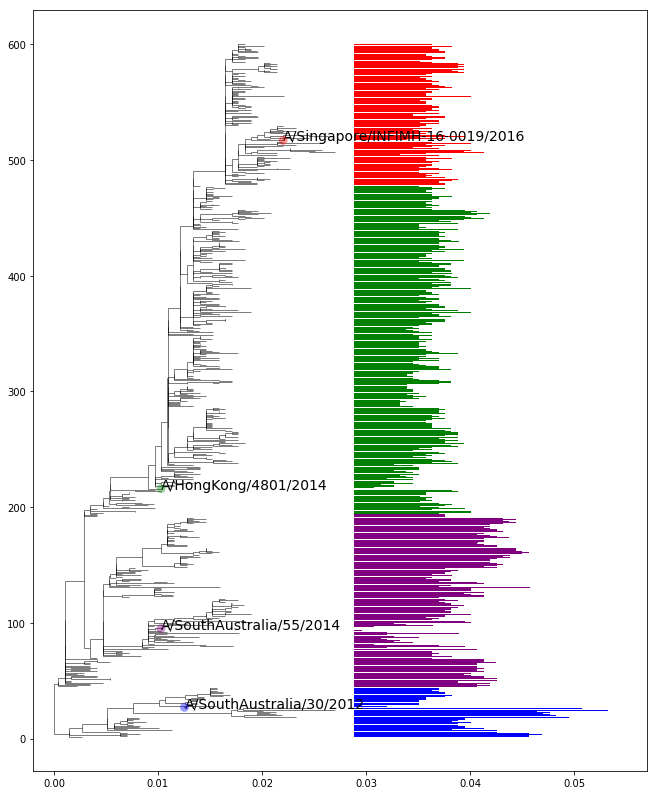

In [7]:
fig,ax = plt.subplots(figsize=(11,14),facecolor='w')

# Init a list to be the input for LineCollection
lines_ls = []

for k in bt_tre.Objects:
    c = 'k'
    x=k.height # raw (x, y) coords
    y=k.y

    xp = k.parent.height
    if x is None: # matplotlib won't plot Nones, like root
        x = 0
    if xp==None:
        xp = x

    if isinstance(k,bt.leaf) or k.branchType=='leaf':        
        # Draw horizontal bars (not including references)
        if k.name.split("|")[0] != "A/H3N2":
            tip_iso_name = k.name.split("|")[1]
            bar_width = dm.loc[dm["iso_name"]==tip_iso_name]["min_dist"].values[0]
            clade_label = dm.loc[dm["iso_name"]==tip_iso_name]["clade_label_iso_name"].values[0].replace("'", "")
            ax.plot([track_x, track_x+bar_width], [y, y], color=label_cdict[clade_label], lw=branchWidth*2)
        # Demarcate reference locations
        # Not all reference need be printed out; only user-selected ones
        else:
            if k.name in ref_names_ls2:
                ax.scatter(x,y,s=s,
                           facecolor=label_cdict[k.name.split("|")[1]],
                           edgecolor='none',
                           zorder=11, 
                           alpha=0.4)
                ax.text(x, y, 
                        k.name.split("|")[1], 
                        color="k",
                        size=14)

    elif isinstance(k,bt.node) or k.branchType=='node':
        line = np.array([[x, k.children[0].y], [x, k.children[-1].y]])
        lines_ls.append(line)

    line = np.array([[xp, y], [x, y]])
    lines_ls.append(line)
        
line_collection = LineCollection(lines_ls, lw=branchWidth,color='k', zorder=9)
ax.add_collection(line_collection)


# set x limits
plt.xlim(-0.002, 0.057)
# Switch off the axis
#plt.axis("off")
#plt.savefig("H3_test.pdf")
plt.show()

Some remarks about the bar chart: this method of computation seems *mostly*, but not perfectly, correct. Also note that there should be a further thresholding step: i.e. sequences where even the distance to the *nearest* reference is still "too far" should not qualify for that reference label. Ideally, we'd have a maximum cutoff threshold that's a high percentile; this histogram is to guide us in setting that cutoff.